In [1]:
%reload_ext autoreload
%autoreload 2
%aimport -sklearn, matplotlib, numpy, seaborn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import binary_assessment 
import calibration 
%matplotlib inline

# Set plotting aesthetics

In [3]:
mpl.rcParams.update({'font.size': 15})
mpl.rcParams.update({"axes.grid" : True, "grid.linestyle": '--', 
                     "grid.alpha": 0.8, "grid.color": "black"})
mpl.rcParams.update({"lines.linewidth" : 3})

# Read data and create training/calibration/test splits
### (calibration split is like a validation split)

In [4]:
data = np.loadtxt('credit.csv', delimiter=',', dtype=str, skiprows=2)
np.random.seed(42)
X = data[:,1:-1]
Y = data[:,-1].astype('int')
X = preprocessing.scale(X)

X, x_test, Y, y_test = train_test_split(
    X, Y, test_size=5000)

x_train, x_calib, y_train, y_calib = train_test_split(
    X, Y, test_size=5000)

print("Number of training points = {:d}".format(x_train.shape[0]))
print("Number of calibration points = {:d}".format(x_calib.shape[0]))
print("Number of test points = {:d}".format(x_test.shape[0]))

Number of training points = 20000
Number of calibration points = 5000
Number of test points = 5000


# Train base logistic regression model

In [5]:
logistic_regression = LogisticRegression().fit(x_train, y_train)

print('Train accuracy: ', logistic_regression.score(x_train, y_train))
print('Calibration accuracy: ', logistic_regression.score(x_calib, y_calib))
print('Test accuracy: ', logistic_regression.score(x_test, y_test))

Train accuracy:  0.8103
Calibration accuracy:  0.8162
Test accuracy:  0.8074


# Assess logistic regression

Using 15 adaptive bins for plotting reliability diagram.
Using 15 adaptive bins for making validity plot.
Using 15 adaptive bins for ECE estimation.


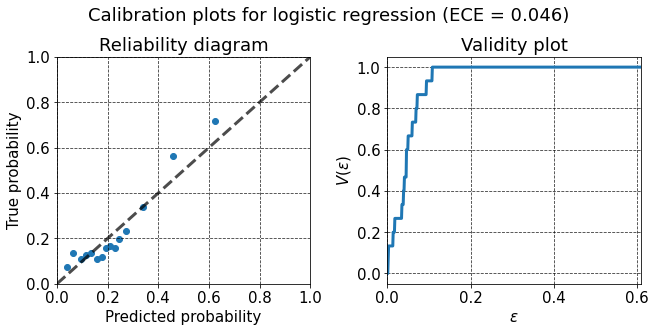

In [11]:
# get logistic regression probabilities on test data
pred_probs_test = logistic_regression.predict_proba(x_test)[:,1]

# make some plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4.5), constrained_layout=True)
binary_assessment.reliability_diagram(y_test, pred_probs_test, ax[0])

binary_assessment.validity_plot(y_test, pred_probs_test, ax[1])
fig.suptitle('Calibration plots for logistic regression (ECE = {:.3f})'.format(binary_assessment.ece(y_test, pred_probs_test)));
ax[0].set_title('Reliability diagram')
ax[1].set_title('Validity plot');

# Recalibrate using histogram binning

In [7]:
# initialize recalibrator and set number of bins
hb = calibration.HB_binary(n_bins=15)

In [8]:
# recalibrate output of logistic regression
pred_probs_calib = logistic_regression.predict_proba(x_calib)[:,1]
hb.fit(pred_probs_calib, y_calib)

# Assess histogram binning

In [9]:
# get logistic regression probabilities on test data
pred_probs_test_lr = logistic_regression.predict_proba(x_test)[:,1]

# get histogram binning probabilities from logistic probabilities
pred_probs_test_hb = hb.predict_proba(pred_probs_test_lr)

Classifier has discrete output. Further binning not done for plotting reliability diagram.
Classifier has discrete output. Further binning not done for making validity plot.
Classifier has discrete output. Further binning not done for ECE estimation.


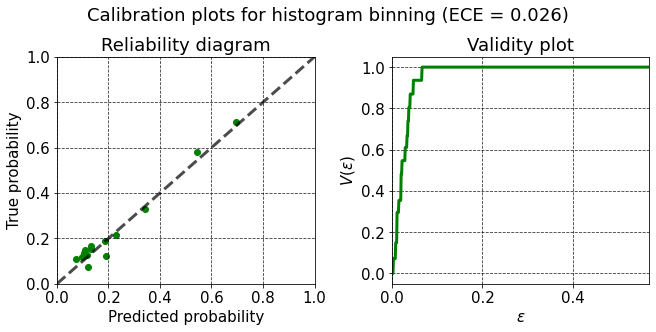

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4.5), constrained_layout=True)

binary_assessment.reliability_diagram(y_test, pred_probs_test_hb, ax[0], color='g')
binary_assessment.validity_plot(y_test, pred_probs_test_hb, ax[1], color='g')
fig.suptitle('Calibration plots for histogram binning (ECE = {:.3f})'.format(binary_assessment.ece(y_test, pred_probs_test_hb)));
ax[0].set_title('Reliability diagram')
ax[1].set_title('Validity plot');